# LightGBM Training
This notebook implements the training process for the LightGBM model to predict various target variables. It includes data preparation, model training, and evaluation.

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import sys
import os


# Set visualization style
sns.set(style='whitegrid')

: 

In [14]:
# Fix the path to find our modules
import sys
import os

# Debug: Check current working directory
print(f"Current working directory: {os.getcwd()}")

# Get the absolute path to the project root
# When running in Jupyter, we need to go up from notebooks to project root
if os.path.basename(os.getcwd()) == 'notebooks':
    project_dir = os.path.dirname(os.getcwd())
else:
    project_dir = os.path.join(os.getcwd(), '..')
    
project_dir = os.path.abspath(project_dir)
sys.path.insert(0, project_dir)

print(f"Added to path: {project_dir}")
print(f"Looking for: {os.path.join(project_dir, 'src', 'data', 'preprocessing.py')}")

# Check if the file exists
preprocessing_path = os.path.join(project_dir, 'src', 'data', 'preprocessing.py')
print(f"File exists: {os.path.exists(preprocessing_path)}")

# List what's in the src directory
if os.path.exists(os.path.join(project_dir, 'src')):
    print(f"Contents of src/: {os.listdir(os.path.join(project_dir, 'src'))}")
    print(f"Contents of src/data/: {os.listdir(os.path.join(project_dir, 'src', 'data'))}")

# Load the dataset
df = pd.read_csv('../../model_2/data/final/final.csv')

# Now import the preprocessing module
from src.data.preprocessing import preprocess_data
X, y = preprocess_data(df)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\n✓ Training samples: {X_train.shape[0]}")
print(f"✓ Test samples: {X_test.shape[0]}")
print(f"✓ Features: {X_train.shape[1]}")
print(f"✓ Targets: {y_train.shape[1]}")

Current working directory: /Users/lionlucky7/01.Projects/In-progress/soccer_prediction/soccer-prediction-advanced-models/notebooks
Added to path: /Users/lionlucky7/01.Projects/In-progress/soccer_prediction/soccer-prediction-advanced-models
Looking for: /Users/lionlucky7/01.Projects/In-progress/soccer_prediction/soccer-prediction-advanced-models/src/data/preprocessing.py
File exists: True
Contents of src/: ['visualization', 'training', 'models', 'data']
Contents of src/data/: ['__init__.py', 'preprocessing.py']
🚀 LightGBM Multi-Target Training Pipeline
🚀 STARTING DATA PREPROCESSING
Mode: simple
Input shape: (9859, 224)

📊 Simple preprocessing mode
🔄 Aggregating player-season data...
✓ Aggregated to 9461 player-season records
✓ Available features: 32/32
✓ Available targets: 14/14
✓ Final dataset - Features: (9461, 32), Targets: (9461, 14)

✓ Training samples: 7568
✓ Test samples: 1893
✓ Features: 32
✓ Targets: 14


In [16]:
# Train separate LightGBM model for each target with loss curves
print(f"\n🌟 TRAINING LIGHTGBM MODELS FOR {y_train.shape[1]} TARGETS")
print("="*55)

models = {}
training_histories = {}
results = []

# Train separate model for each target
for i, target in enumerate(y_train.columns):
    print(f"📈 Training model {i+1}/{y_train.shape[1]}: {target}")
    
    # Split training data for validation
    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
        X_train, y_train[target], test_size=0.2, random_state=42
    )
    
    # Define the LightGBM model
    lgb_model = lgb.LGBMRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=-1,
        min_child_samples=20,
        random_state=42,
        verbose=-1
    )
    
    # Train the model with validation monitoring
    lgb_model.fit(
        X_train_split, y_train_split,
        eval_set=[(X_train_split, y_train_split), (X_val_split, y_val_split)],
        eval_names=['train', 'val'],
        callbacks=[
            lgb.early_stopping(stopping_rounds=10, verbose=False),
            lgb.log_evaluation(0)
        ]
    )
    
    # Store model and history
    models[target] = lgb_model
    training_histories[target] = lgb_model.evals_result_
    
    # Make predictions
    y_pred_train = lgb_model.predict(X_train)
    y_pred_test = lgb_model.predict(X_test)
    
    # Evaluate the model
    train_mse = mean_squared_error(y_train[target], y_pred_train)
    test_mse = mean_squared_error(y_test[target], y_pred_test)
    train_r2 = r2_score(y_train[target], y_pred_train)
    test_r2 = r2_score(y_test[target], y_pred_test)
    train_mae = mean_absolute_error(y_train[target], y_pred_train)
    test_mae = mean_absolute_error(y_test[target], y_pred_test)
    
    results.append({
        'target': target,
        'train_mse': round(train_mse, 4),
        'test_mse': round(test_mse, 4),
        'train_r2': round(train_r2, 4),
        'test_r2': round(test_r2, 4),
        'train_mae': round(train_mae, 4),
        'test_mae': round(test_mae, 4)
    })
    
    print(f"   ✓ Test R²: {test_r2:.4f}, MAE: {test_mae:.4f}")

# Display results
results_df = pd.DataFrame(results)
print(f"\n🎯 LIGHTGBM PERFORMANCE SUMMARY:")
print(results_df)


🌟 TRAINING LIGHTGBM MODELS FOR 14 TARGETS
📈 Training model 1/14: Per_90_Minutes_npxG
   ✓ Test R²: 0.9270, MAE: 0.0039
📈 Training model 2/14: Per_90_Minutes_xG
   ✓ Test R²: 0.9364, MAE: 0.0039
📈 Training model 3/14: Standard_Sh/90
   ✓ Test R²: 0.7889, MAE: 0.1973
📈 Training model 4/14: Per_90_Minutes_xAG
   ✓ Test R²: 0.9877, MAE: 0.0012
📈 Training model 5/14: KP
   ✓ Test R²: 0.9845, MAE: 0.1722
📈 Training model 6/14: SCA_SCA90
   ✓ Test R²: 0.8982, MAE: 0.1006
📈 Training model 7/14: Progression_PrgP
   ✓ Test R²: 0.9947, MAE: 0.5471
📈 Training model 8/14: Progression_PrgC
   ✓ Test R²: 0.9297, MAE: 5.9092
📈 Training model 9/14: Carries_PrgDist
   ✓ Test R²: 0.9954, MAE: 14.8439
📈 Training model 10/14: Tkl+Int
   ✓ Test R²: 0.9885, MAE: 0.6411
📈 Training model 11/14: Blocks_Blocks
   ✓ Test R²: 0.9936, MAE: 0.4301
📈 Training model 12/14: Aerial_Duels_Won
   ✓ Test R²: 0.9609, MAE: 0.4333
📈 Training model 13/14: Touches_Touches
   ✓ Test R²: 0.9774, MAE: 75.2117
📈 Training model 14/

In [ ]:
# Make predictions
# (Moved to the per-target training loop above)

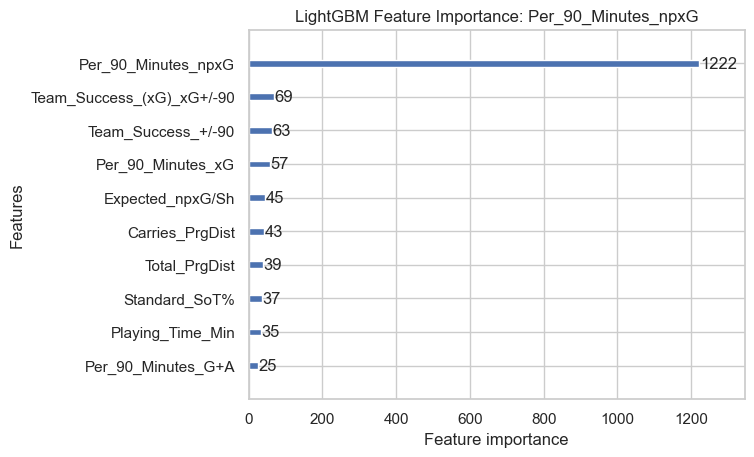

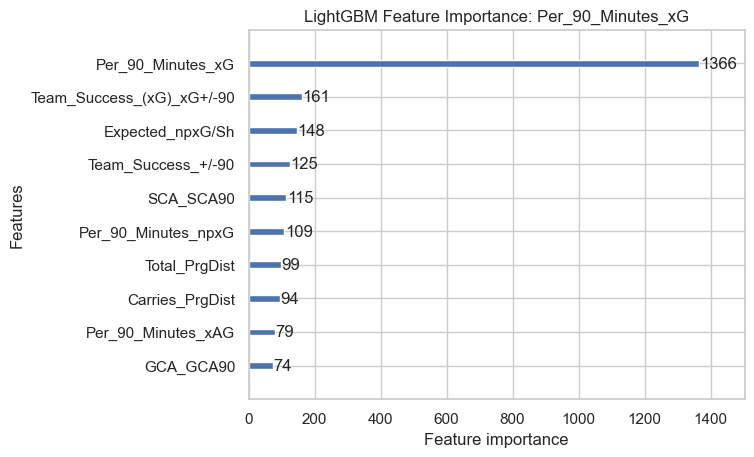

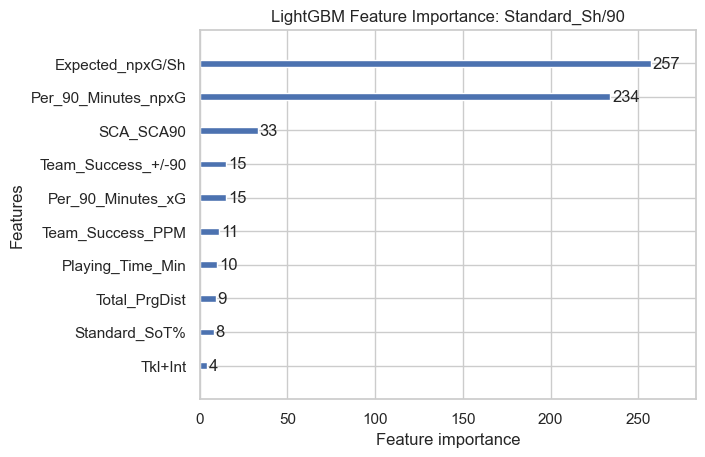

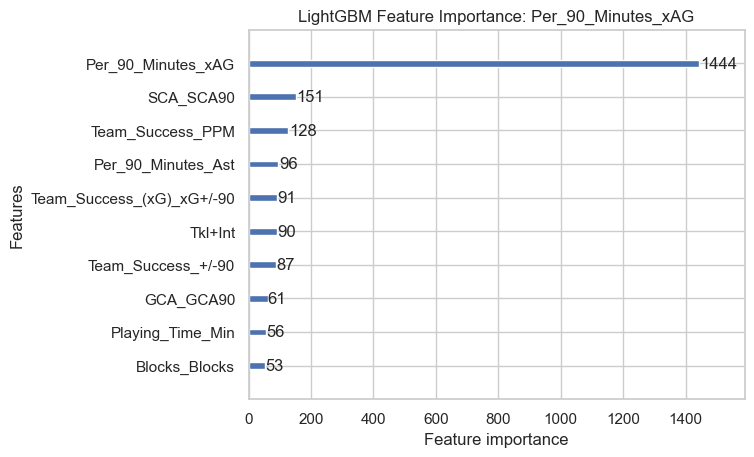

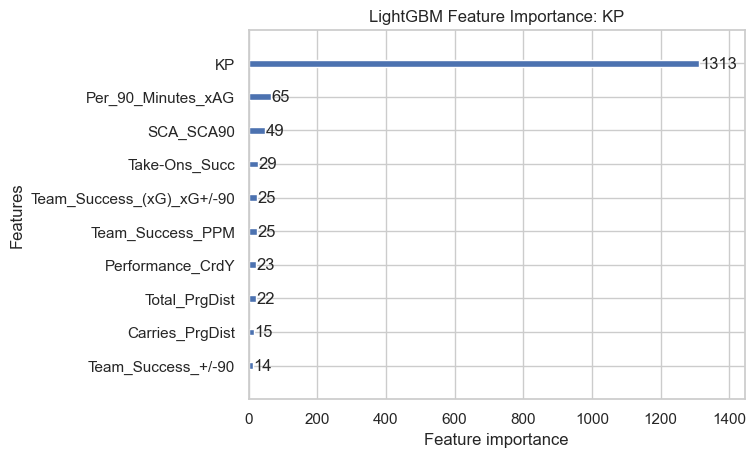

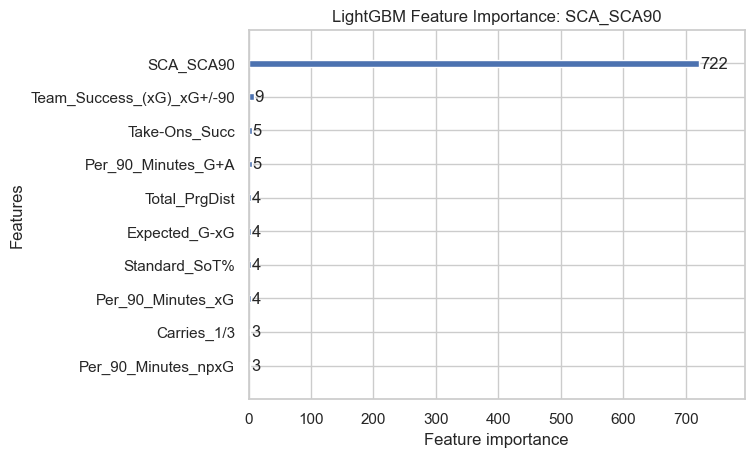

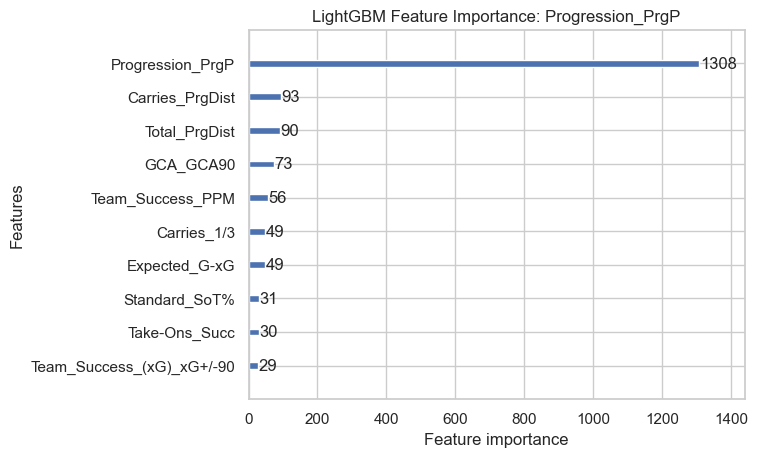

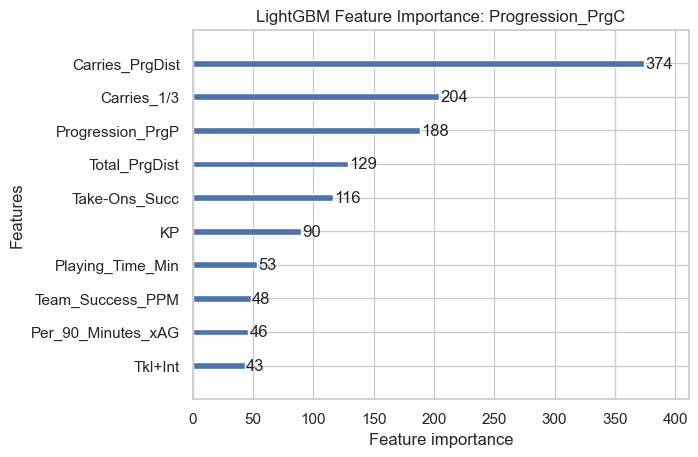

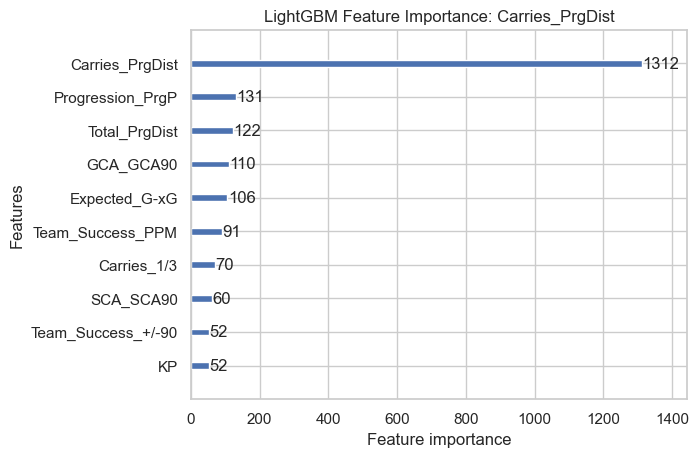

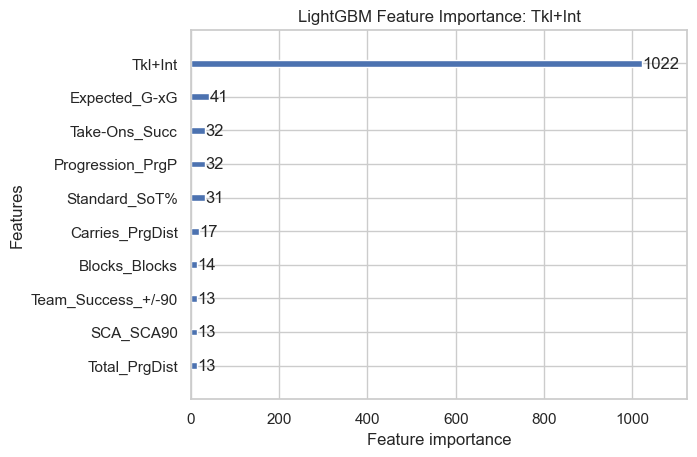

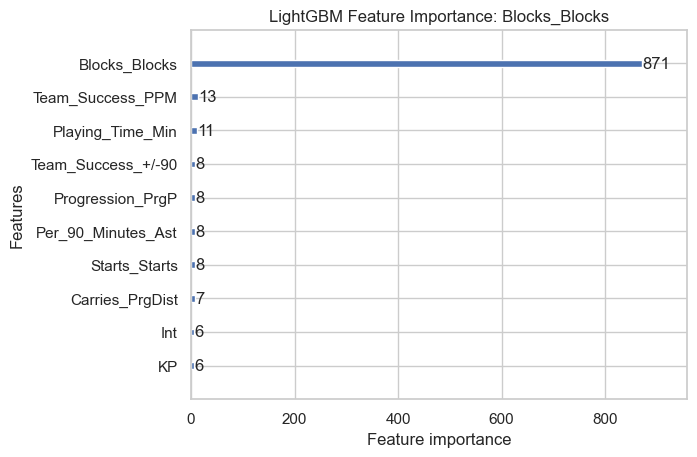

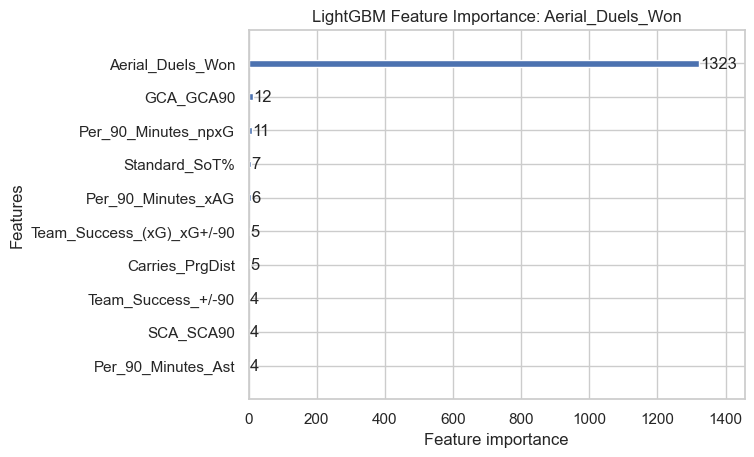

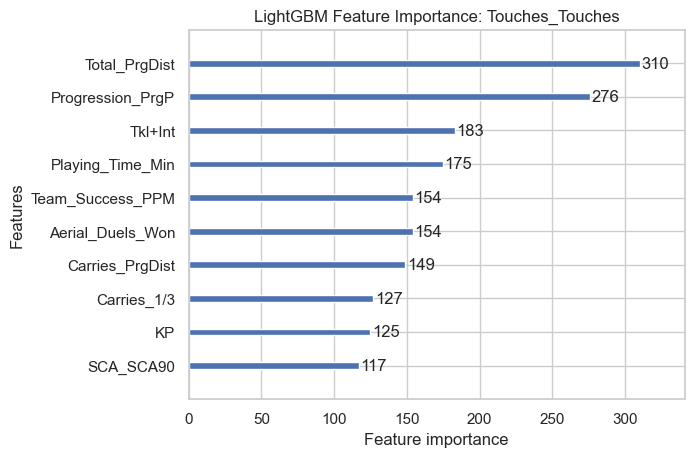

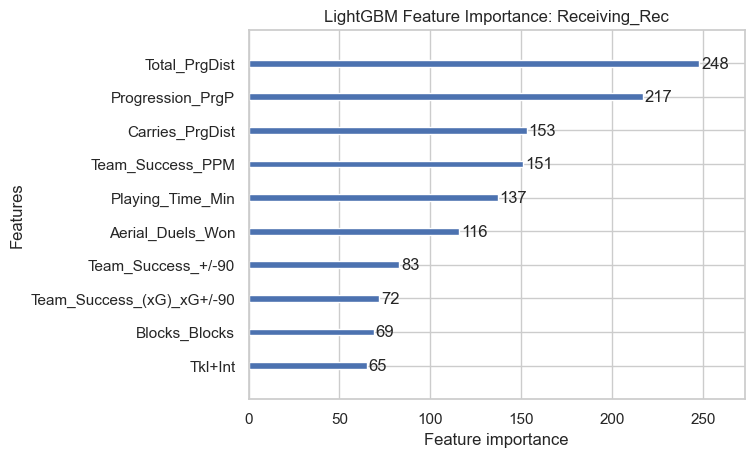

In [17]:
# Visualize feature importance for each target
for target in models:
    lgb.plot_importance(models[target], max_num_features=10, importance_type='split')
    plt.title(f'LightGBM Feature Importance: {target}')
    plt.show()

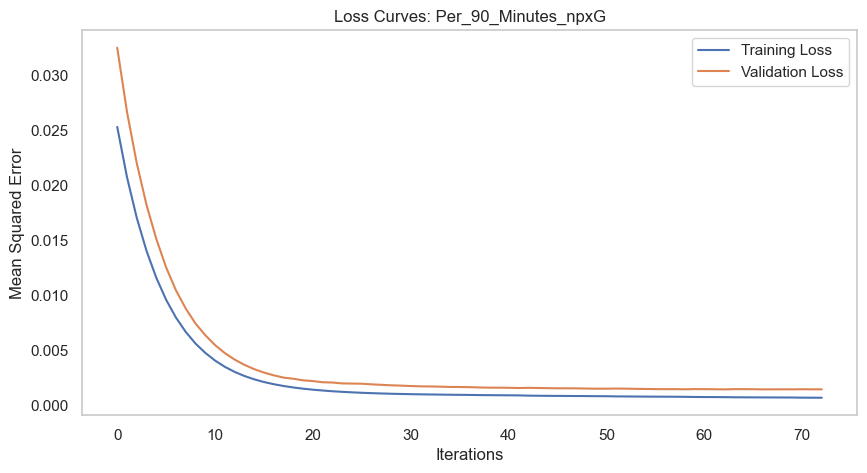

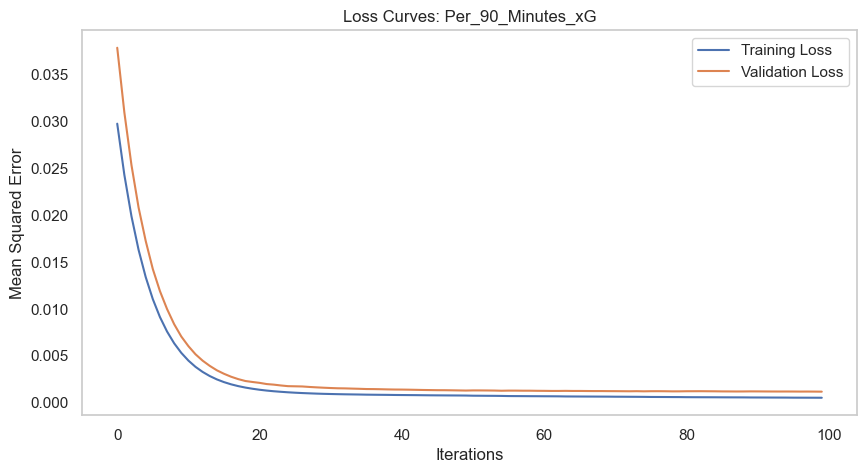

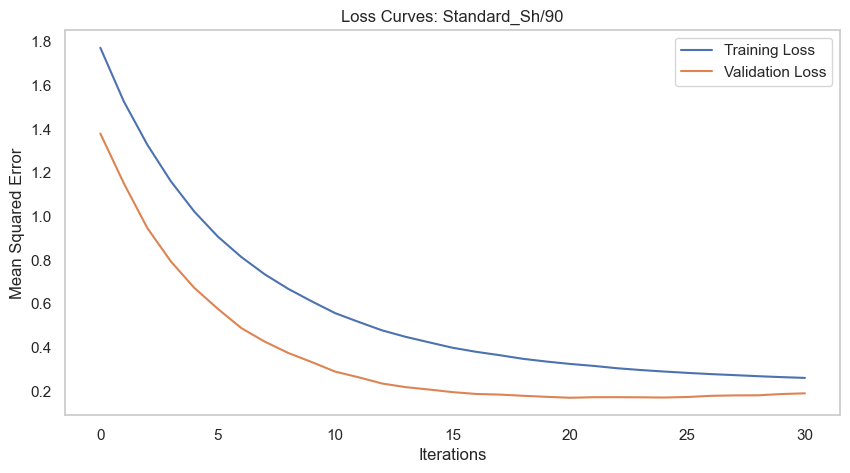

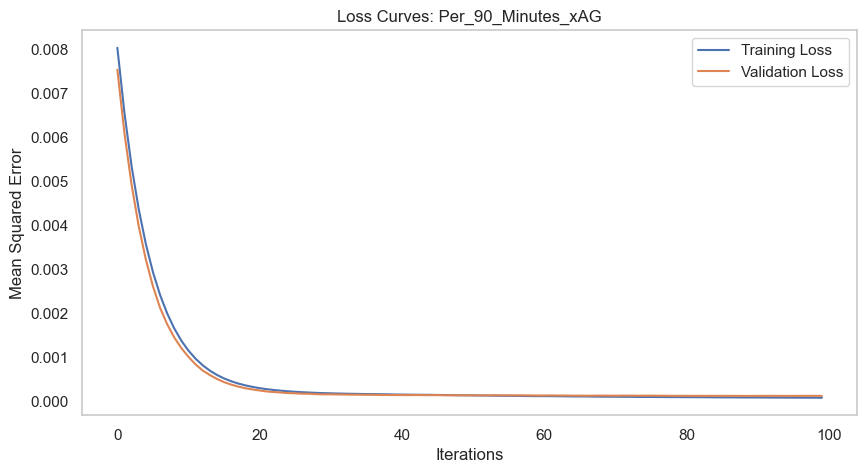

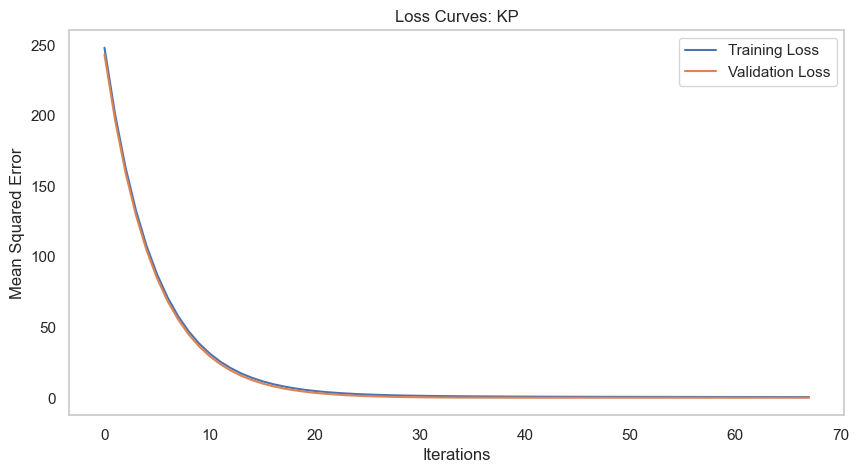

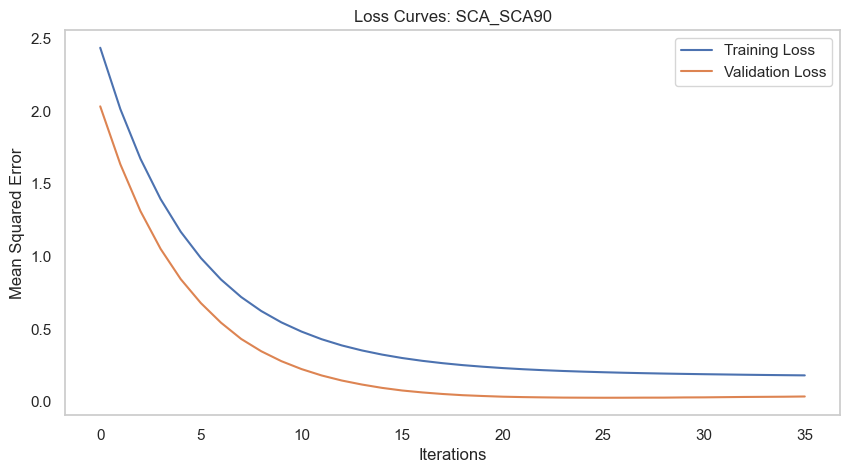

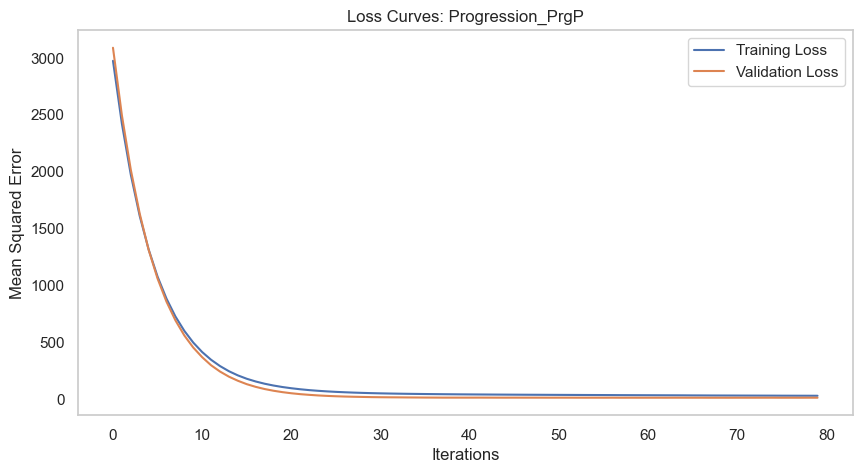

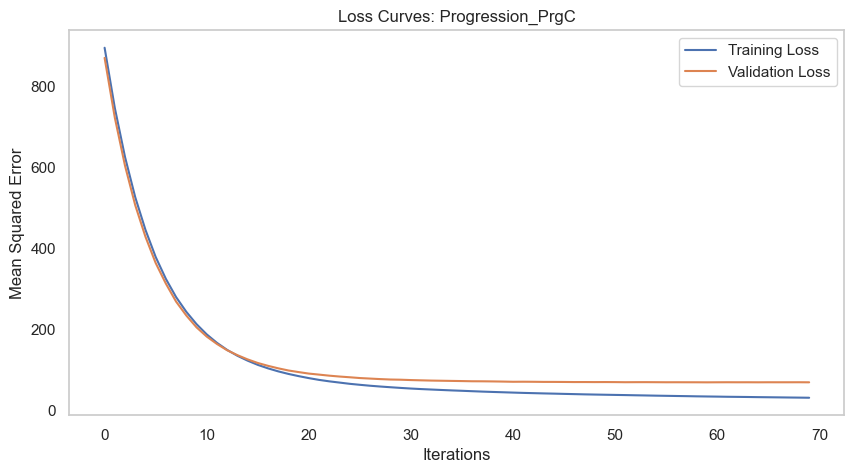

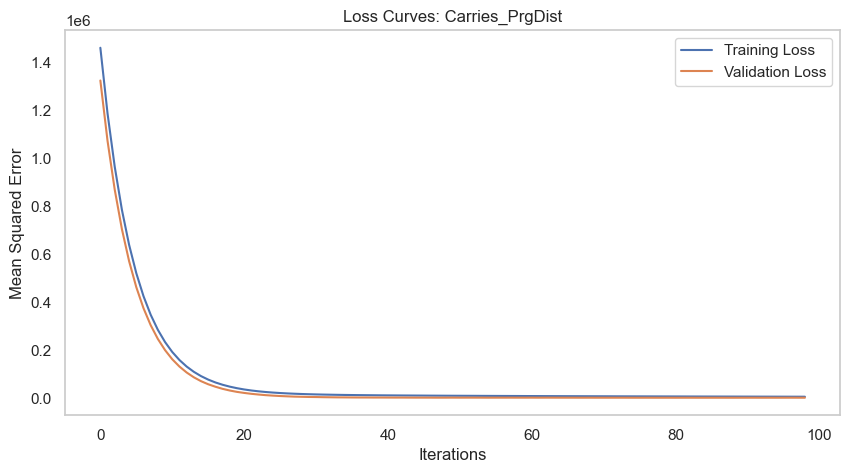

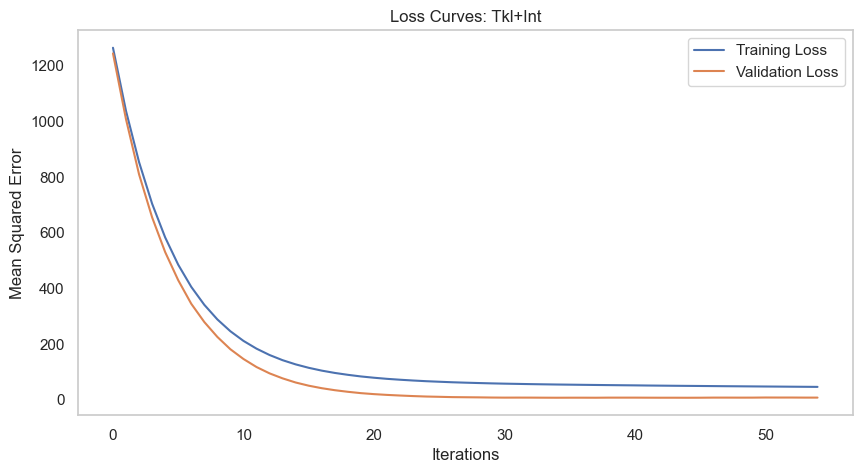

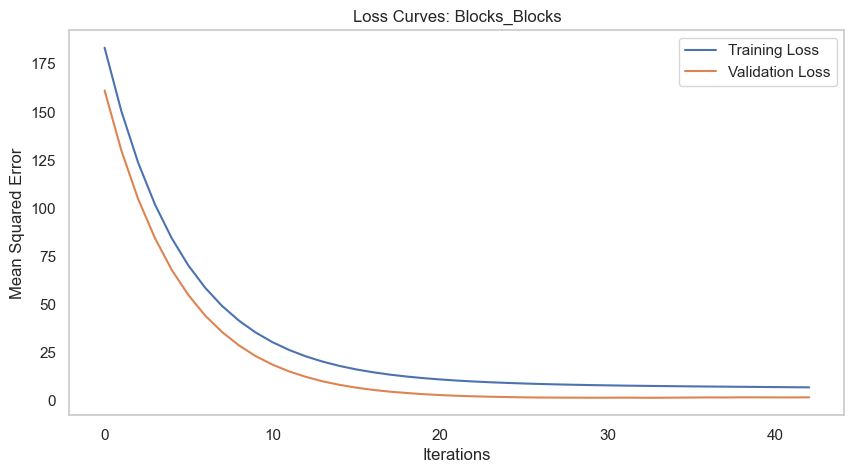

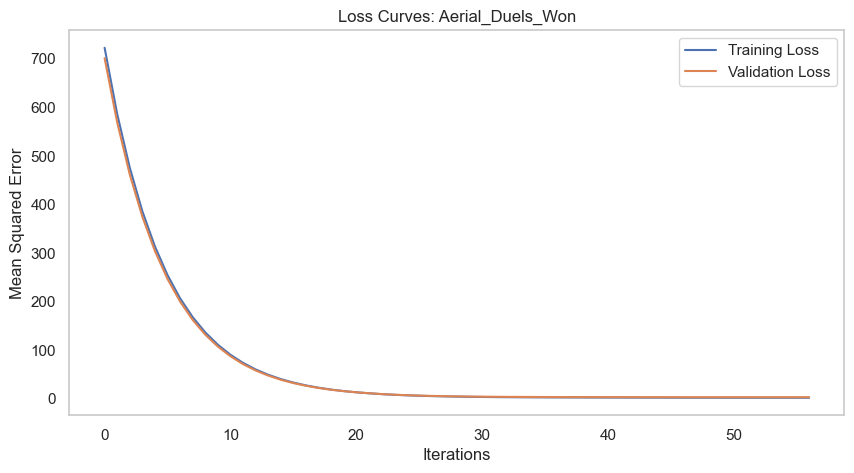

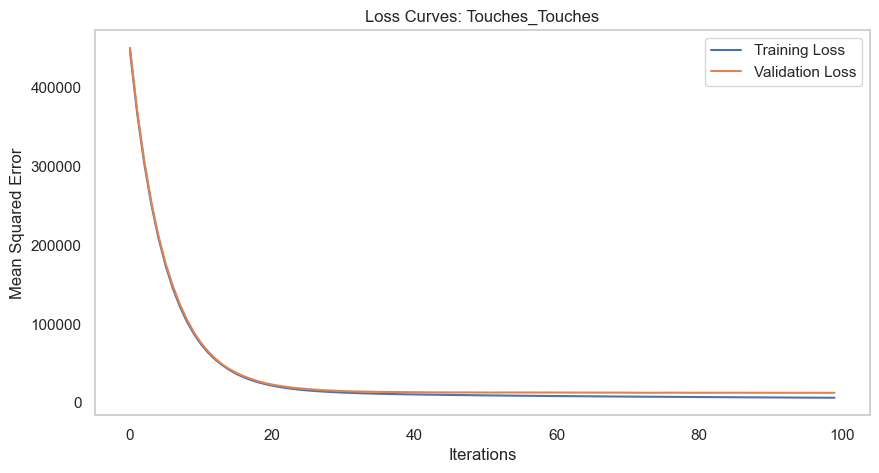

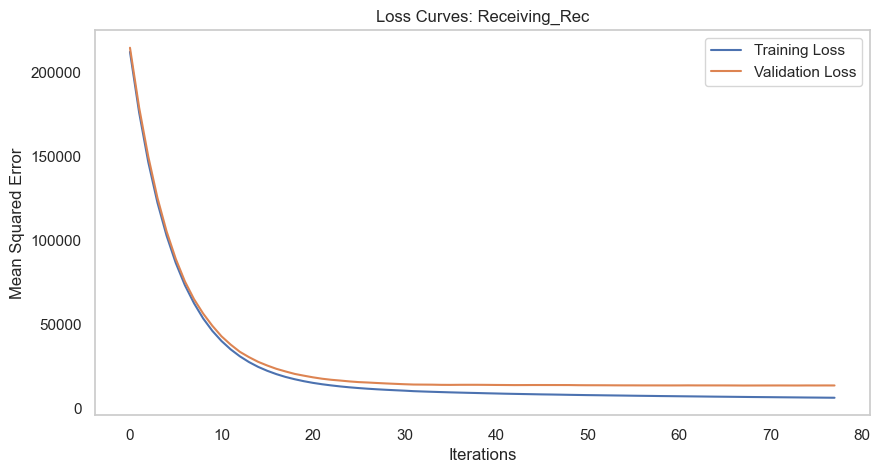

In [18]:
# Visualize loss curves for each target
for target in training_histories:
    train_loss = training_histories[target]['train']['l2']
    val_loss = training_histories[target]['val']['l2']

    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title(f'Loss Curves: {target}')
    plt.xlabel('Iterations')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.grid()
    plt.show()